# XGBoost Model

# Importing the libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import xgboost as xgb
from sklearn.utils import _joblib

import numpy as np
import pandas as pd

# Importing the dataset

In [2]:
dataset = pd.read_csv('../data/processed/final_data.csv')
X = dataset.iloc[:, 2:-1].values    # Exclude the first two columns user_id and product_id
y = dataset.iloc[:, -1].values

# Feature Scaling

In [3]:
# sc = StandardScaler()
# X = sc.fit_transform(X[:, 4:])
# X

## Encoding categorical data
### One Hot Encoding

In [4]:
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder='passthrough'
)
X = np.array(ct.fit_transform(X).toarray())

# Splitting the dataset into the Training set and Test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0
)

In [6]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4891, 1035)
Number transactions y_train dataset:  (4891,)
Number transactions X_test dataset:  (2097, 1035)
Number transactions y_test dataset:  (2097,)


# Applying SMOTE because the dataset is imbalanced (more 0 than 1)

In [15]:
smote = SMOTE(random_state=2)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Training the XGBoost on the Training set

In [8]:
classifier = XGBClassifier(
    reg_lambda=1.0, 
    scale_pos_weight=1, 
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
)
classifier.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Predicting the Test set results

In [9]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1669
           1       0.31      0.07      0.11       428

    accuracy                           0.78      2097
   macro avg       0.56      0.51      0.49      2097
weighted avg       0.70      0.78      0.72      2097



# Making the Confusion Matrix

In [10]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1605   64]
 [ 399   29]]


0.7792083929422985

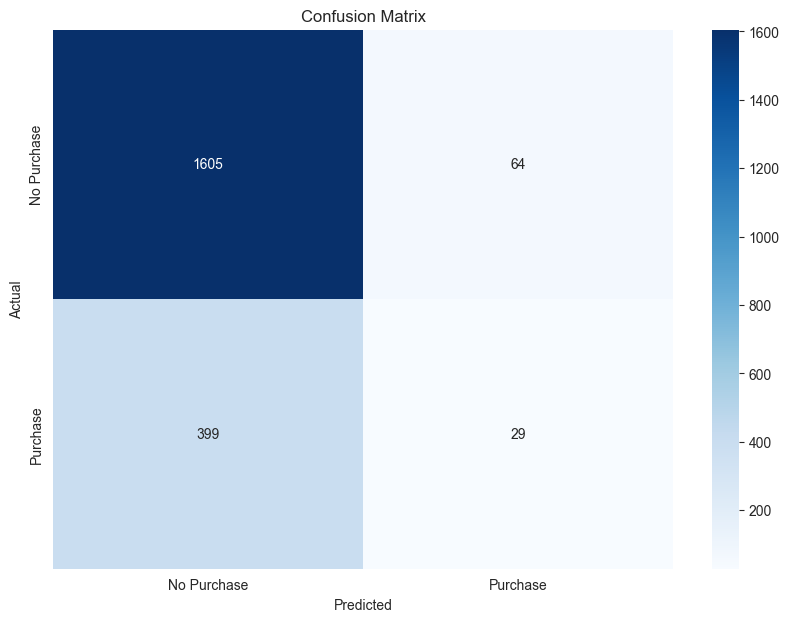

In [11]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Applying k-Fold Cross Validation

In [12]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 77.14 %
Standard Deviation: 0.73 %


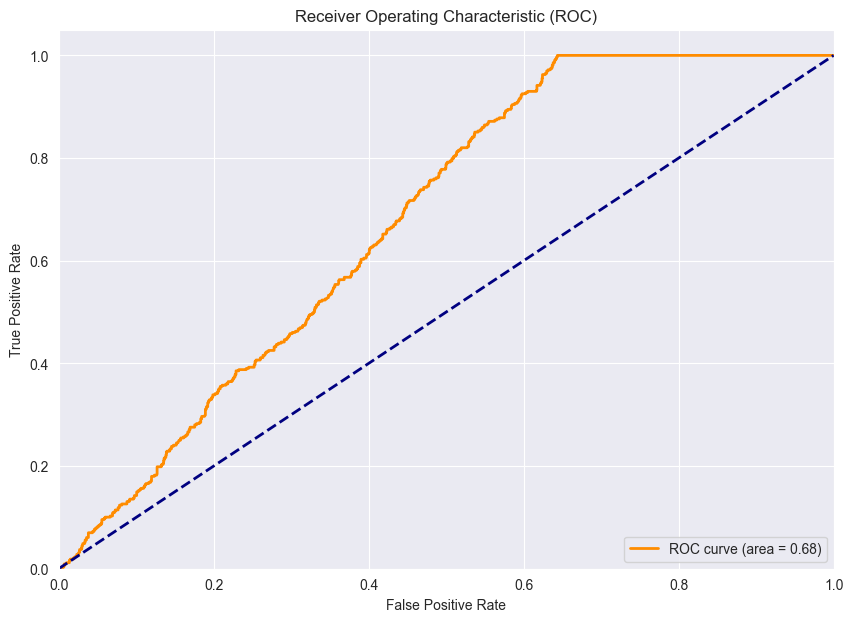

In [13]:
# Compute prediction probabilities
y_prob = classifier.predict_proba(X_test)[:, 1]

# Calculates the values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# View the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Save the model

In [14]:
_joblib.dump(classifier, 'xgboost.joblib')

['xgboost.joblib']